# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

# Global params
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df, area='M1'):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_ = pyal.remove_low_firing_neurons(df, f"{area}_spikes", 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    
    df_ = pyal.sqrt_transform_signal(df_, f"{area}_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names




---

back to the original idea:

1. this:
> # Compare different epochs
> the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

2. and a similar but different idea:
> two monkeys during the same epoch vs. one monkey between 2 different epochs.
i.e., preparation vs execution, ...

#### Try the second idea first:

##### 2 monkeys, same epoch


load the data

In [4]:
GoodDataList[areas[0]]

{'Chewie': ['Chewie_CO_VR_2016-09-14.mat',
  'Chewie_CO_FF_2016-10-13.mat',
  'Chewie_CO_CS_2016-10-21.mat',
  'Chewie_CO_CS_2016-10-14.mat'],
 'Chewie2': ['Chewie_CO_CS_2015-03-19.mat',
  'Chewie_CO_CS_2015-03-13.mat',
  'Chewie_CO_CS_2015-03-11.mat',
  'Chewie_CO_CS_2015-03-12.mat'],
 'Mihili': ['Mihili_CO_VR_2014-03-06.mat',
  'Mihili_CO_VR_2014-03-03.mat',
  'Mihili_CO_FF_2014-02-17.mat'],
 'Jaco': ['Jaco_CO_CS_2016-01-28.mat',
  'Jaco_CO_CS_2016-02-04.mat',
  'Jaco_CO_CS_2016-02-17.mat']}

In [7]:
'sdfsdsd' + '23423534'

'sdfsdsd23423534'

In [13]:
pairFileList1 = []
for i, animal1 in enumerate(GoodDataList[areas[0]]):
    for j, animal2 in enumerate(GoodDataList[areas[0]]):
        if j<=i or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[0]][animal2][i] for i,_ in enumerate(GoodDataList[areas[0]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList1.append((df1, dt.load_pyal_data(path2)))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for i, animal1 in enumerate(GoodDataList[areas[1]]):
    for j, animal2 in enumerate(GoodDataList[areas[1]]):
        if j<=i or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[1]][animal2][i] for i,_ in enumerate(GoodDataList[areas[1]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList2.append((df1, dt.load_pyal_data(path2)))

print(f'{len(pairFileList2)=}')


warnings.filterwarnings("ignore")
gc.collect()
pairFileList_area0 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList1]
del pairFileList1
gc.collect()
pairFileList_area1 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList2]
del pairFileList2
gc.collect()
warnings.filterwarnings("default")

len(pairFileList1)=33
len(pairFileList2)=33


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=16
min_time=15
min_trials_=15
min_time_=15


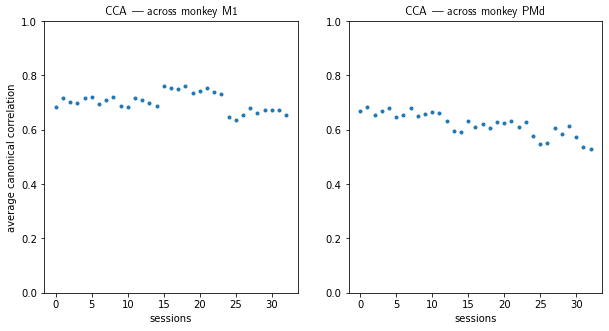

In [27]:
# warnings.filterwarnings("ignore")
side1df = [df for df,_ in pairFileList_area0]
side2df = [df for _,df in pairFileList_area0]
AllData1 = dt.get_data_array(side1df, exec_epoch, area=areas[0], n_components=n_components)
AllData2 = dt.get_data_array(side2df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')
CCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    CCs0.append(np.mean(dt.canoncorr(data1, data2)[:4]))
CCs0 = np.array(CCs0)
# PMd
side1df = [df for df,_ in pairFileList_area1]
side2df = [df for _,df in pairFileList_area1]
AllData1_ = dt.get_data_array(side1df, prep_epoch, area=areas[1], n_components=n_components)
AllData2_ = dt.get_data_array(side2df, prep_epoch, area=areas[1], n_components=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')
CCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    CCs1.append(np.mean(dt.canoncorr(data1, data2)[:4]))
CCs1 = np.array(CCs1)
# warnings.filterwarnings("default")

# plotting
fig,axes = plt.subplots(ncols=2, figsize=(10,5))

axes[0].plot(CCs0.T,'.')
axes[1].plot(CCs1.T,'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- across monkey {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')


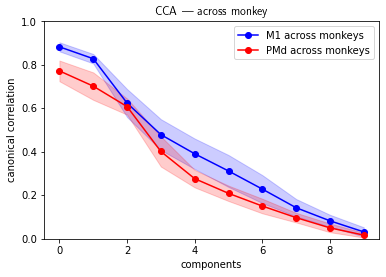

In [28]:
allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    allCCs1.append(dt.canoncorr(data1, data2))
allCCs1 = np.array(allCCs1).T

# plot
_,ax = plt.subplots()

utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{areas[0]} across monkeys')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{areas[1]} across monkeys')

ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

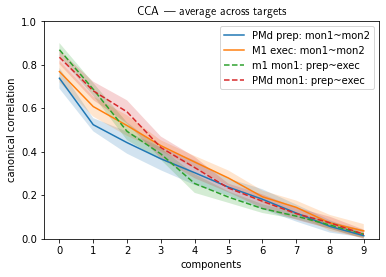

In [7]:
fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs_prep = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_prep]
    dfs_exec = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_exec]
    
    # PMd prep: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
    # M1 exec: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
    # m1 mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
    # PMd mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::4,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::4,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::4,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::4,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);

similar results from prep~exec of Monkey2:


---

what about the VAF?  
I'll look at VAF, instead of correlation, in the plot above

In [5]:
def prep_general (df):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth')
    
    
    return df_


df_data_ready = [prep_general(df) for  df in df_data]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-15, rel_end=1)
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-1, rel_end=15)

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


 the cell below does not correct for different number of units

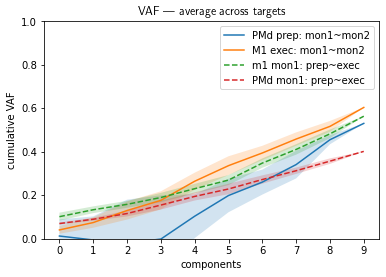

In [6]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

The cell below corrects for disparate number of units:

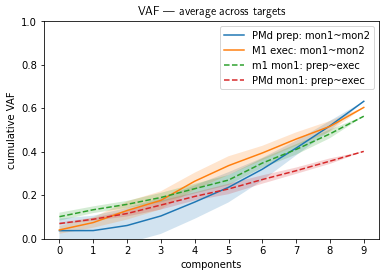

In [7]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

---
## Working on all datasets

In [11]:
%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [ ]:

for animal, sessionList in GoodDataList['PMd'].items():
    session
    
    
    
    
df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
    dt.summary(df)
    
    
df_data_prep = [prep_prep_all_targets(df) for  df in df_data]
df_data_exec = [prep_exec_all_targets(df) for  df in df_data]




fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs_prep = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_prep]
    dfs_exec = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_exec]
    
    # PMd prep: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
    # M1 exec: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
    # m1 mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
    # PMd mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::4,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::4,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::4,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::4,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);